In [1]:
!pip install -U --pre tensorflow=="2.*"

     |████████████████████████████████| 320.3MB 47kB/s 
     |████████████████████████████████| 460kB 44.6MB/s 
  Found existing installation: tensorflow 2.2.0
    Uninstalling tensorflow-2.2.0:
      Successfully uninstalled tensorflow-2.2.0


In [2]:
!pip install pycocotools

In [3]:
import os
import pathlib

if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2679, done.
remote: Counting objects: 100% (2679/2679), done.
remote: Compressing objects: 100% (2350/2350), done.
remote: Total 2679 (delta 521), reused 1330 (delta 296), pack-reused 0
Receiving objects: 100% (2679/2679), 55.63 MiB | 26.89 MiB/s, done.
Resolving deltas: 100% (521/521), done.


In [4]:
cd models/research

/content/models/research


In [5]:
!protoc object_detection/protos/*.proto --python_out=.

object_detection/protos/input_reader.proto: warning: Import object_detection/protos/image_resizer.proto but not used.


In [6]:
!pip install object_detection

     |████████████████████████████████| 1.5MB 2.7MB/s 


In [7]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

In [8]:
ls

a3c_blogpost/                      lm_1b/
adversarial_crypto/                lm_commonsense/
adversarial_logit_pairing/         lstm_object_detection/
adversarial_text/                  marco/
adv_imagenet_models/               maskgan/
attention_ocr/                     namignizer/
audioset/                          neural_gpu/
autoaugment/                       neural_programmer/
autoencoder/                       next_frame_prediction/
brain_coder/                       nst_blogpost/
cognitive_mapping_and_planning/    object_detection/
cognitive_planning/                pcl_rl/
compression/                       ptn/
cvt_text/                          qa_kg/
deep_contextual_bandits/           README.md
deeplab/                           real_nvp/
deep_speech/                       rebar/
delf/                              sentiment_analysis/
domain_adaptation/                 seq2species/
efficient-hrl/                     setup.py
feelvos/                           skip_thoughts/
f

In [9]:
!pip install tf_slim


     |████████████████████████████████| 358kB 2.8MB/s 


In [10]:
from object_detection.utils import ops as utils_ops

In [11]:
from object_detection.utils import label_map_util

In [12]:
from object_detection.utils import visualization_utils as vis_util

In [13]:
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tf.saved_model.load(str(model_dir))
  model = model.signatures['serving_default']

  return model

In [14]:
PATH_TO_LABELS = 'object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [15]:
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('object_detection/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

[PosixPath('object_detection/test_images/image1.jpg'),
 PosixPath('object_detection/test_images/image2.jpg')]

In [16]:
model_name = 'ssd_mobilenet_v1_coco_2017_11_17'
detection_model = load_model(model_name)

76537856/76534733 [==============================] - 1s 0us/step
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [17]:
print(detection_model.inputs)
detection_model.output_dtypes

[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]


{'detection_boxes': tf.float32,
 'detection_classes': tf.float32,
 'detection_scores': tf.float32,
 'num_detections': tf.float32}

In [18]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  output_dict = model(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

Here in the below function (show_inference) the third argument (class_id) will help you to detect the class you want.

In [19]:
def show_inference(model, image_path,class_id):
  image_np = np.array(Image.open(image_path))
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  boxes = []
  classes = []
  scores = []
  for i,x in enumerate(output_dict['detection_classes']):
    if x==class_id and output_dict['detection_scores'][i] > 0.5:
      classes.append(x)
      boxes.append(output_dict['detection_boxes'][i])
      scores.append(output_dict['detection_scores'][i])
  boxes = np.array(boxes)
  classes = np.array(classes)
  scores = np.array(scores)
  
 
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      boxes,
      classes,
      scores,
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=2)
  

  display(Image.fromarray(image_np))
  
  
  
  

Now in the following cell while you are calling the show_inference function, You have to pass the third argument as the class id which you can get in models/research/object_detection/data/mscoco_label_map.pbtxt file.
As an example the class_id in the following cell is kept as 1 which corresponds to class = "Person" and hence are the results.

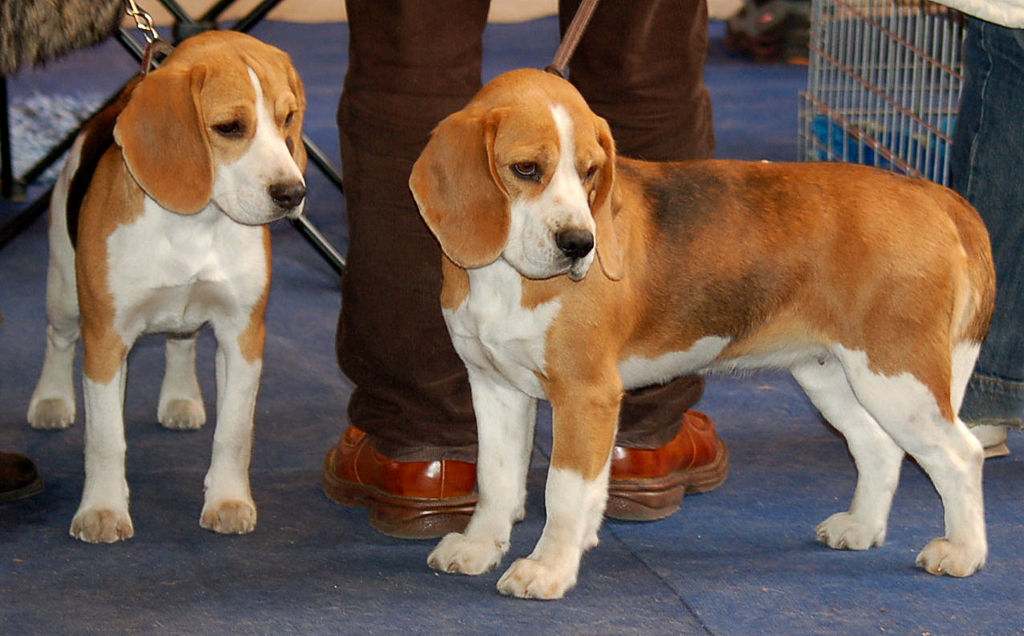

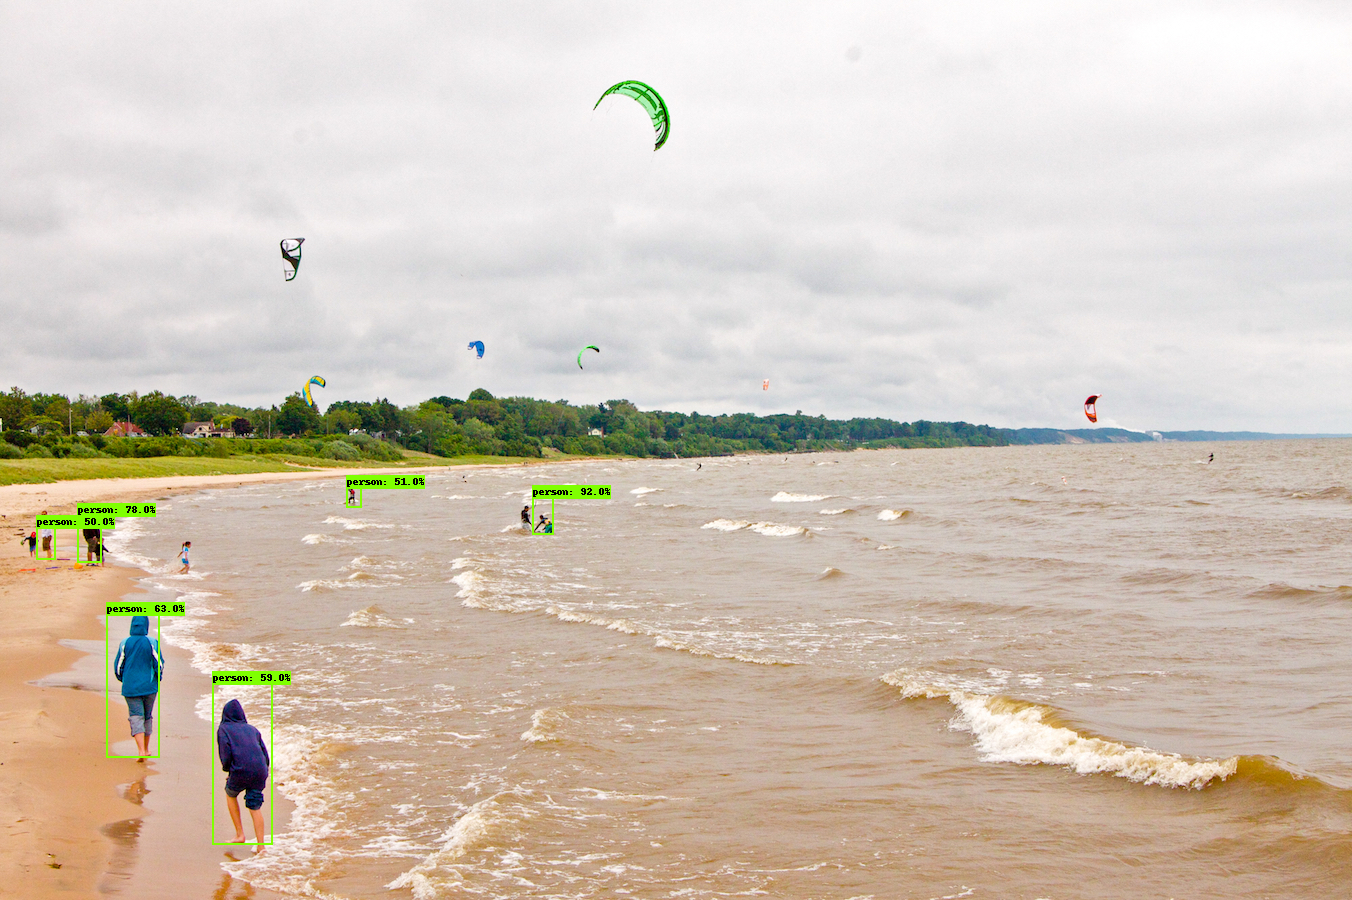

In [20]:
for image_path in TEST_IMAGE_PATHS:
  show_inference(detection_model, image_path, 1)